# Flat $P(k)$ Analysis

Bobby Pascua and the HERA Validation Team

<h3 id="tocheading">Table of Contents</h3>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Setup and Metadata

### Abstract

This notebook aims to validate the accuracy of the hera_pspec pipeline with simulated observational data of a Gaussian sky. The goal is to determine the amplitude of the resulting power spectrum and compare the calculated result with the expected result. We find agreement to better than 1%, with the hera_pspec pipeline over-estimating the power spectrum amplitude by 0.45%.

### Imports

In [2]:
%matplotlib inline
from IPython.display import Markdown
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from pyuvdata import UVData
import hera_pspec as hp
import copy
import os
import itertools
from funcsigs import signature
from scipy.special import gamma
from hera_pspec.data import DATA_PATH

In [3]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

### Description

In [4]:
print("Last executed: ", datetime.now())

('Last executed: ', datetime.datetime(2019, 5, 7, 16, 46, 7, 646425))


- **Major Step Description:** Validate measured $P(k)$ for simulated white $P(k)$
- **Minor Variation Description:** Compute histogram of measured power spectrum values and compare with expected distribution
- **Pipelines Tested:** hera_pspec
- **Criteria**:
  1. Measured amplitude of $P(k)$ agrees with expected amplitude
  2. Histogram of measured power spectrum values agrees with predicted distribution
  

### Summary

The results of this validation test, in reference to the outlined criteria, are
1. The measured power spectrum amplitude is consistent with the expected amplitude to within 1%
2. The measured power spectrum histogram is consistent with an exponential distribution

### Software

HERA software used in this validation test, with associate git commit hash:

* ``pyuvdata``: `a8f6b6fdd7261`
* ``hera_qm``: `f3e32c3cef36cbd`
* ``hera_pspec``: `d2de2ffd9908b76ccb79a2fc83a0caee903f0d72`
* ``uvtools``: `f7d1ec748ee64593f4a97c4b5c265703de76c692`


Versions of other software used in this validation test:

* ``numpy``: v1.15.4
* etc. (only list imported modules).

### Data

The following paths reflect the exact locations of all data used in this test:

In [5]:
path1 = '/lustre/aoc/projects/hera/alanman/eor_sky_sim/eorsky_3.00hours_Nside128_sigma0.03_fwhm12.13_uv.uvh5'
# This is the path used to retrieve the data from the NRAO cluster

## Measuring $P(k)$

In this section, we measure the amplitude of the power spectrum. We perform the measurement by first calculating power spectra for all auto-baseline pairs, then averaging the resulting power spectra first over time for each baseline, then over baselines, then over delay modes. We show the results by plotting the baseline-averaged spectrum, the spectrum's average, and the predicted amplitude on the same figure. We also examine the measured power spectrum amplitude for each auto-baseline pair at a particular, randomly-chosen time.

In [6]:
# Load in the data

dfile = os.path.join(DATA_PATH, 'eorsky_3.00hours_Nside128_sigma0.03_fwhm12.13_uv.uvh5')

uvd = UVData()
uvd.read_uvh5(dfile)

# Use the standard cosmology

cosmo = hp.conversions.Cosmo_Conversions()

# Load in the extra keywords

bm_fwhm = np.radians(uvd.extra_keywords[u'bm_fwhm'])
bsq_int = uvd.extra_keywords[u'bsq_int']
nside = uvd.extra_keywords[u'nside']
skysig = uvd.extra_keywords[u'skysig']

Telescope eorsky is not in known_telescopes.


In [7]:
# 21-cm rest-frame frequency
f0 = 1420.4057511 * 1e6

# Take observed frequency to be band-center frequency
fobs = np.median(uvd.freq_array[0])

# Compute redshift
z = f0/fobs - 1

# Compute X2Y using the Cosmo_Conversions method
X2Y = cosmo.X2Y(z)

# Compute Omega, according to above definition
Omega = 4*np.pi/(12*nside**2)

# Use frequency bin size for df
df = (uvd.freq_array[0][1:]-uvd.freq_array[0][:-1]).mean()

# Compute expected power spectrum amplitude
# skysig is in units of K, so need to convert to mK
sig_amp = (1e3*skysig)**2*Omega*df*X2Y

print('Expected amplitude: {} [mK units]'.format(sig_amp))

Expected amplitude: 2845952.29398 [mK units]


In [8]:
# Construct beam object
beam_freqs = uvd.freq_array[0]
beam = hp.PSpecBeamGauss(fwhm=bm_fwhm, beam_freqs=beam_freqs, 
                         cosmo=cosmo)

# Compute beam-squared integral with hera_pspec, compare to expected
OmegaPP = beam.power_beam_sq_int()
bsq_int_diff = np.abs(OmegaPP.mean() - bsq_int)
print('Discrepancy in beam-squared integral: {:2.2f}%'.format(100*bsq_int_diff/bsq_int))

Discrepancy in beam-squared integral: 0.15%


In [9]:
# Convert visibilities to mK units
uvd.data_array *= beam.Jy_to_mK(np.unique(uvd.freq_array))[None, None, :, None]

# Split visibilities into two datasets, offset in time
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False) # even indices
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False) # odd indices

# Construct PSD object using split visibility data
psd = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=beam)

# Construct PSD object with no time offset between visibilities
psd0 = hp.PSpecData(dsets=[uvd,uvd], wgts=[None, None], beam=beam)

# Get baselines
baselines = uvd.get_antpairs()

# Construct baseline pair arrays
baselines1, baselines2, blpairs = hp.utils.construct_blpairs(baselines,
                                                             exclude_auto_bls=False,
                                                             exclude_permutations=True)

# Rephase dataset and set visibilities to mK units
psd.rephase_to_dset(0)
psd.dsets[0].vis_units = 'mK'
psd.dsets[1].vis_units = 'mK'

# No need to rephase dataset constructed with no time offset
psd0.dsets[0].vis_units = 'mK'
psd0.dsets[1].vis_units = 'mK'

# Only using one spectral window; polarization is Stokes I
spw = 0
pol = 'pI'

In [10]:
# Compute power spectra with no taper

# Power spectra for time-offset visibilities
uvp = psd.pspec(baselines1, baselines2, (0,1), [(pol, pol)],
                spw_ranges=None, input_data_weight='identity',
                norm='I', taper='none', little_h=True, verbose=True)

# Power spectra for full visibilities
uvp0 = psd0.pspec(baselines1, baselines2, (0,1), [(pol, pol)],
                  spw_ranges=None, input_data_weight='identity',
                  norm='I', taper='none', little_h=True, verbose=True)

blpair ((0, 11), (0, 12)) exceeds redundancy tolerance of 1.0 m
blpair ((0, 11), (11, 12)) exceeds redundancy tolerance of 1.0 m
blpair ((0, 12), (11, 12)) exceeds redundancy tolerance of 1.0 m

Setting spectral range: (0, 384)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((0, 11), (0, 12))
pol: (1, 1)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 11), (11, 12))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 12), (11, 12))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 11), (0, 11))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 12), (0, 12))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((

In [11]:
# Compute power spectra using blackman-harris taper

# Power spectra for time-offset visibilities
tapered_uvp = psd.pspec(baselines1, baselines2, (0,1), [('pI', 'pI')],
                        spw_ranges=None, input_data_weight='identity',
                        norm='I', taper='blackman-harris', little_h=True, verbose=True)

# Power spectra for full visibilities
tapered_uvp0 = psd0.pspec(baselines1, baselines2, (0,1), [('pI', 'pI')],
                          spw_ranges=None, input_data_weight='identity',
                          norm='I', taper='blackman-harris', little_h=True, verbose=True)

blpair ((0, 11), (0, 12)) exceeds redundancy tolerance of 1.0 m
blpair ((0, 11), (11, 12)) exceeds redundancy tolerance of 1.0 m
blpair ((0, 12), (11, 12)) exceeds redundancy tolerance of 1.0 m

Setting spectral range: (0, 384)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((0, 11), (0, 12))
pol: (1, 1)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 11), (11, 12))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 12), (11, 12))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 11), (0, 11))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 12), (0, 12))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((

In [12]:
# Compute delays
dlys = uvp.get_dlys(spw) * 1e9

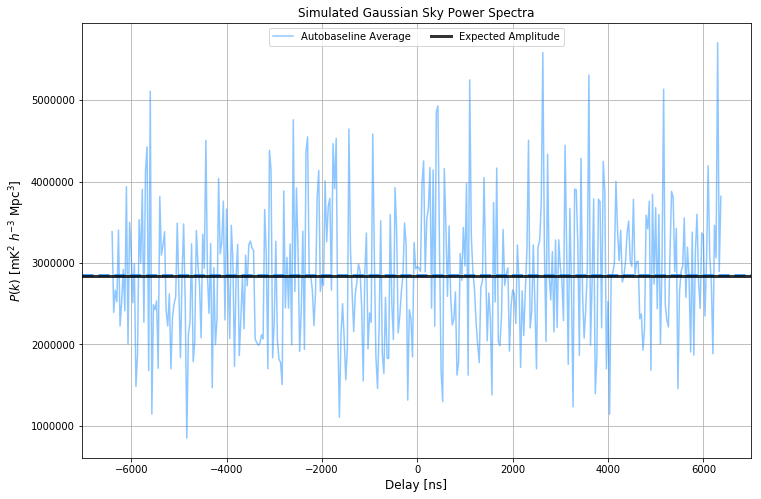

In [13]:
# Look at the auto-baseline average, first for time-offset visibilities,
# then for no offset

# The average spectrum is produced by averaging each baseline pair's
# spectra over all observing times, then averaging those results over
# all auto-baseline pairs

auto_avgs = []
auto_spec = []
cross_avgs = []
cross_spec = []
shifted = True

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Delay [ns]', fontsize=12)
ax.set_ylabel(r'$P(k)$ [mK$^2$ $h^{-3}$ Mpc$^3$]', fontsize=12)
ax.set_title('Simulated Gaussian Sky Power Spectra', fontsize=12)
ax.grid()

for blp in blpairs:
    key = (spw, blp, pol)
    flag = blp[0]==blp[1]
    if shifted:
        shiftlabel = 'Shifted'
        power = np.abs(np.real(uvp.get_data(key))).mean(axis=0)
    else:
        shiftlabel = 'Unshifted'
        power = np.abs(np.real(uvp0.get_data(key))).mean(axis=0)
    avg_power = power.mean()
    if flag:
        auto_avgs.append(avg_power)
        auto_spec.append(power)
    else:
        cross_avgs.append(avg_power)
        cross_spec.append(power)
        
    
auto_avg = np.array(auto_avgs).mean()
cross_avg = np.array(cross_avgs).mean()
auto_spec_avg = np.array(auto_spec).mean(axis=0)
cross_spec_avg = np.array(cross_spec).mean(axis=0)

ax.plot(dlys, auto_spec_avg, color='dodgerblue', alpha=0.5, label='Autobaseline Average')
#ax.plot(dlys, cross_spec_avg, color='slategray', alpha=0.5, label='Cross-baseline Average')
ax.axhline(auto_avg, color='dodgerblue', lw=3, ls='--', alpha=0.8)
#ax.axhline(cross_avg, color='slategray', lw=3, ls='--', alpha=0.8)
ax.axhline(sig_amp, color='k', lw=3, alpha=0.8, label='Expected Amplitude')
plt.legend(ncol=3, loc='upper center')

#fig.savefig('Gaussian_Sky_Spectra_Obs_Time_Average_{}.pdf'.format(shiftlabel))
#fig.savefig('Gaussian_Sky_Spectra_Obs_Time_Average_{}.png'.format(shiftlabel))
plt.show()

**Figure 1** | Comparison of baseline-averaged power spectrum to expected power spectrum amplitude. The power spectrum plotted was computed by first averaging each baseline's power spectrum over time, then averaging over baselines. This spectrum was computed using the time-offset visibilities. Note that the absolute value of the real component is plotted.

In [14]:
# Take a look at the fractional difference between the
# averaged signal amplitude and the predicted amplitude
print('Discrepancy in measured amplitude: {:2.2f}%'.format(100*(sig_amp-auto_avg)/sig_amp))

Discrepancy in measured amplitude: -0.45%


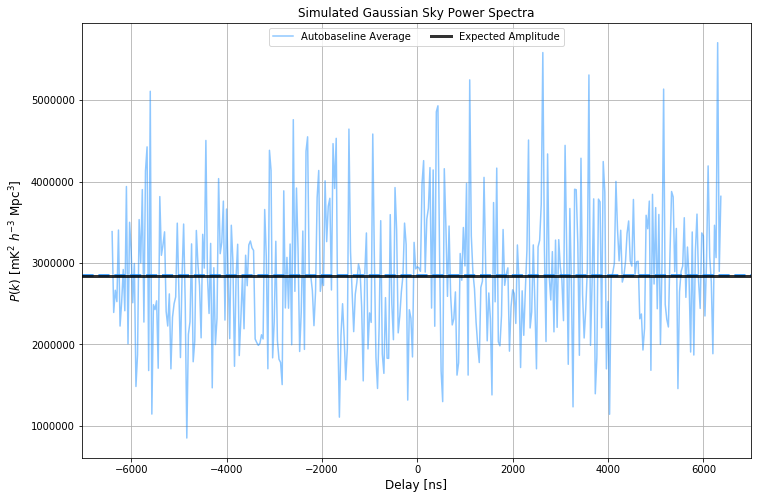

In [15]:
# Look at the auto-baseline average for no offset

auto_avgs = []
auto_spec = []
cross_avgs = []
cross_spec = []
shifted = False

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Delay [ns]', fontsize=12)
ax.set_ylabel(r'$P(k)$ [mK$^2$ $h^{-3}$ Mpc$^3$]', fontsize=12)
ax.set_title('Simulated Gaussian Sky Power Spectra', fontsize=12)
ax.grid()

for blp in blpairs:
    key = (spw, blp, pol)
    flag = blp[0]==blp[1]
    if shifted:
        shiftlabel = 'Shifted'
        power = np.abs(np.real(uvp.get_data(key))).mean(axis=0)
    else:
        shiftlabel = 'Unshifted'
        power = np.abs(np.real(uvp0.get_data(key))).mean(axis=0)
    avg_power = power.mean()
    if flag:
        auto_avgs.append(avg_power)
        auto_spec.append(power)
    else:
        cross_avgs.append(avg_power)
        cross_spec.append(power)
        
    
auto_avg = np.array(auto_avgs).mean()
cross_avg = np.array(cross_avgs).mean()
auto_spec_avg = np.array(auto_spec).mean(axis=0)
cross_spec_avg = np.array(cross_spec).mean(axis=0)

ax.plot(dlys, auto_spec_avg, color='dodgerblue', alpha=0.5, label='Autobaseline Average')
#ax.plot(dlys, cross_spec_avg, color='slategray', alpha=0.5, label='Cross-baseline Average')
ax.axhline(auto_avg, color='dodgerblue', lw=3, ls='--', alpha=0.8)
#ax.axhline(cross_avg, color='slategray', lw=3, ls='--', alpha=0.8)
ax.axhline(sig_amp, color='k', lw=3, alpha=0.8, label='Expected Amplitude')
plt.legend(ncol=3, loc='upper center')

#fig.savefig('Gaussian_Sky_Spectra_Obs_Time_Average_{}.pdf'.format(shiftlabel))
#fig.savefig('Gaussian_Sky_Spectra_Obs_Time_Average_{}.png'.format(shiftlabel))
plt.show()

**Figure 2** | Baseline-averaged spectrum compared to expected power spectrum amplitude. This spectrum was computed the same way as that shown in Figure 1, but for the power spectrum computed with the unshifted visibilities. Note that the absolute value of the real component is plotted here.

In [16]:
# Take a look at the fractional difference between the
# averaged signal amplitude and the predicted amplitude
print('Discrepancy in measured amplitude: {:2.2f}%'.format(100*(sig_amp-auto_avg)/sig_amp))

Discrepancy in measured amplitude: -0.45%


In [17]:
# Confirm that the time-offset only has the effect of transferring power
# from the real component to the imaginary component
p1 = []
p2 = []

for blp in blpairs:
    key = (spw, blp, pol)
    flag = blp[0]==blp[1]
    if flag:
        p1.append(np.abs(uvp.get_data(key)).mean(axis=0).mean())
        p2.append(np.abs(uvp0.get_data(key)).mean(axis=0).mean())
    else:
        pass
    
p1 = np.array(p1).mean()
p2 = np.array(p2).mean()
disc = (p1-p2)/p2
print('Discrepancy in shifted and unshifted amplitudes: {:2.2e}'.format(disc))

Discrepancy in shifted and unshifted amplitudes: -7.72e-06


In [18]:
# Randomly choose a time to inspect
tvalindex = int(np.random.uniform(low=0, high=np.unique(uvp.time_avg_array).shape))

# Restrict our attention to only auto-baseline pairs
autopairs = []
for i in range(len(blpairs)):
    blp = blpairs[i]
    if blp[0]==blp[1]:
        autopairs.append(blp)

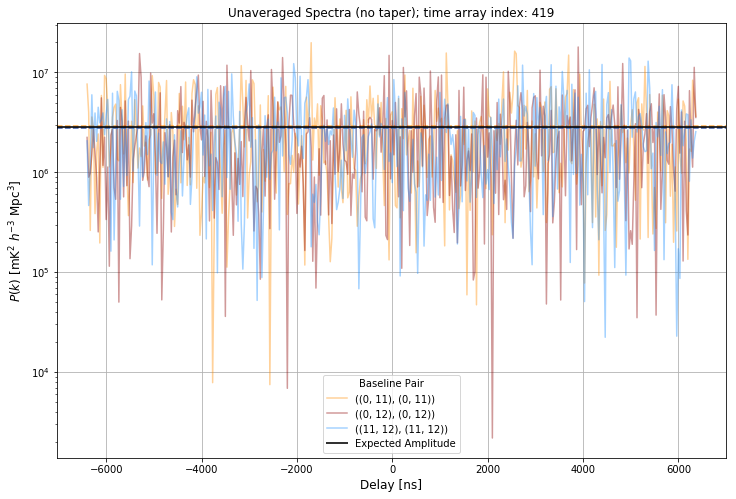

In [19]:
colors = ['darkorange', 'darkred', 'dodgerblue']
taper = False
savefig = False
powers = {}
powers['tapered'] = {}
powers['untapered'] = {}

### Make P(k) plot for all auto-baseline spectra for one particular time
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel('Delay [ns]', fontsize=12)
ax.set_ylabel(r'$P(k)$ [mK$^2$ $h^{-3}$ Mpc$^3$]', fontsize=12)

for i in range(len(autopairs)):
    pair = autopairs[i]
    color = colors[i]
    key = (spw, pair, pol)
    if taper:
        power = np.abs(np.real(tapered_uvp.get_data(key)[tvalindex]))
        powers['tapered'][pair] = power
        ax.set_title('Unaveraged Spectra (B-H taper); time array index: {}'.format(tvalindex), fontsize=12)
    else:
        power = np.abs(np.real(uvp.get_data(key)[tvalindex]))
        powers['untapered'][pair] = power
        ax.set_title('Unaveraged Spectra (no taper); time array index: {}'.format(tvalindex), fontsize=12)
    ax.plot(dlys, power, color=color, alpha=0.4, label=pair)
    ax.axhline(power.mean(), ls='--', color=color, alpha=0.7)
    
ax.axhline(sig_amp, color='k', lw=2, alpha=0.8, label='Expected Amplitude')
legend = ax.legend(loc='lower center')
legend.set_title('Baseline Pair')
plt.show()
if savefig:
    if taper:
        fig.savefig('Spec_bhTaper_noAvg_t{}.pdf'.format(tvalindex))
        fig.savefig('Spec_bhTaper_noAvg_t{}.png'.format(tvalindex))
    else:
        fig.savefig('Spec_noTaper_noAvg_t{}.pdf'.format(tvalindex))
        fig.savefig('Spec_noTaper_noAvg_t{}.png'.format(tvalindex))

**Figure 3** | Auto-baseline spectra for a randomly chosen observation time. The spectra shown were computed without a taper, using the shifted visibilities, and are plotted against the expected power spectrum amplitude.

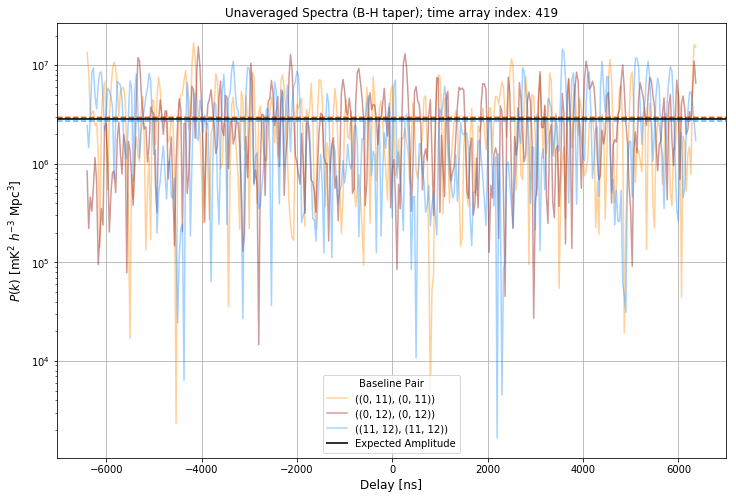

In [20]:
colors = ['darkorange', 'darkred', 'dodgerblue']
taper = True
savefig = False

### Make P(k) plot for all auto-baseline spectra for one particular time
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel('Delay [ns]', fontsize=12)
ax.set_ylabel(r'$P(k)$ [mK$^2$ $h^{-3}$ Mpc$^3$]', fontsize=12)

for i in range(len(autopairs)):
    pair = autopairs[i]
    color = colors[i]
    key = (spw, pair, pol)
    if taper:
        power = np.abs(np.real(tapered_uvp.get_data(key)[tvalindex]))
        powers['tapered'][pair] = power
        ax.set_title('Unaveraged Spectra (B-H taper); time array index: {}'.format(tvalindex), fontsize=12)
    else:
        power = np.abs(np.real(uvp.get_data(key)[tvalindex]))
        powers['untapered'][pair] = power
        ax.set_title('Unaveraged Spectra (no taper); time array index: {}'.format(tvalindex), fontsize=12)
    ax.plot(dlys, power, color=color, alpha=0.4, label=pair)
    ax.axhline(power.mean(), ls='--', color=color, alpha=0.7)
    
ax.axhline(sig_amp, color='k', lw=2, alpha=0.8, label='Expected Amplitude')
legend = ax.legend(loc='lower center')
legend.set_title('Baseline Pair')
plt.show()
if savefig:
    if taper:
        fig.savefig('Spec_bhTaper_noAvg_t{}.pdf'.format(tvalindex))
        fig.savefig('Spec_bhTaper_noAvg_t{}.png'.format(tvalindex))
    else:
        fig.savefig('Spec_noTaper_noAvg_t{}.pdf'.format(tvalindex))
        fig.savefig('Spec_noTaper_noAvg_t{}.png'.format(tvalindex))

**Figure 4** | Auto-baseline spectra for a randomly chosen observation time. The spectra were computed using a Blackman-Harris taper, using the shifted visibilities, and are plotted against the expected power spectrum amplitude.

In [21]:
# Look at the fractional difference between the measured
# and the predicted power spectrum amplitude
print('Discrepancy in measured power spectra amplitudes:')
for key in powers.keys():
    for blp in autopairs:
        discrepancy = (powers[key][blp].mean() - sig_amp)/sig_amp
        print('taper: {}; blp: {}; Discrepancy: {:2.2f}%'.format(key, blp, 100*discrepancy))

Discrepancy in measured power spectra amplitudes:
taper: tapered; blp: ((0, 11), (0, 11)); Discrepancy: 3.68%
taper: tapered; blp: ((0, 12), (0, 12)); Discrepancy: 1.84%
taper: tapered; blp: ((11, 12), (11, 12)); Discrepancy: -4.89%
taper: untapered; blp: ((0, 11), (0, 11)); Discrepancy: 1.29%
taper: untapered; blp: ((0, 12), (0, 12)); Discrepancy: -2.86%
taper: untapered; blp: ((11, 12), (11, 12)); Discrepancy: -3.27%


## The $P(k)$ Distribution ##

In this section, we compute normalized histograms for the measured power spectra for each auto-baseline pair. We compare the mean, median, and mode of each histogram to the expected power spectrum amplitude. We plot the histograms for power spectra computed with and without a taper for all auto-baseline pairs.

In [22]:
# Make dictionary of data for tapered and untapered spectra
autospectra = {}
autospectra['tapered'] = {}
autospectra['untapered'] = {}
for key in autospectra.keys():
    autospectra[key]['shifted'] = {}
    autospectra[key]['unshifted'] = {}

for pair in autopairs:
    key = (spw, pair, pol)
    for skey in autospectra['tapered'].keys():
        if skey=='shifted':
            autospectra['tapered'][skey][pair] = tapered_uvp.get_data(key)
            autospectra['untapered'][skey][pair] = uvp.get_data(key)
        else:
            autospectra['tapered'][skey][pair] = tapered_uvp0.get_data(key)
            autospectra['untapered'][skey][pair] = uvp0.get_data(key)

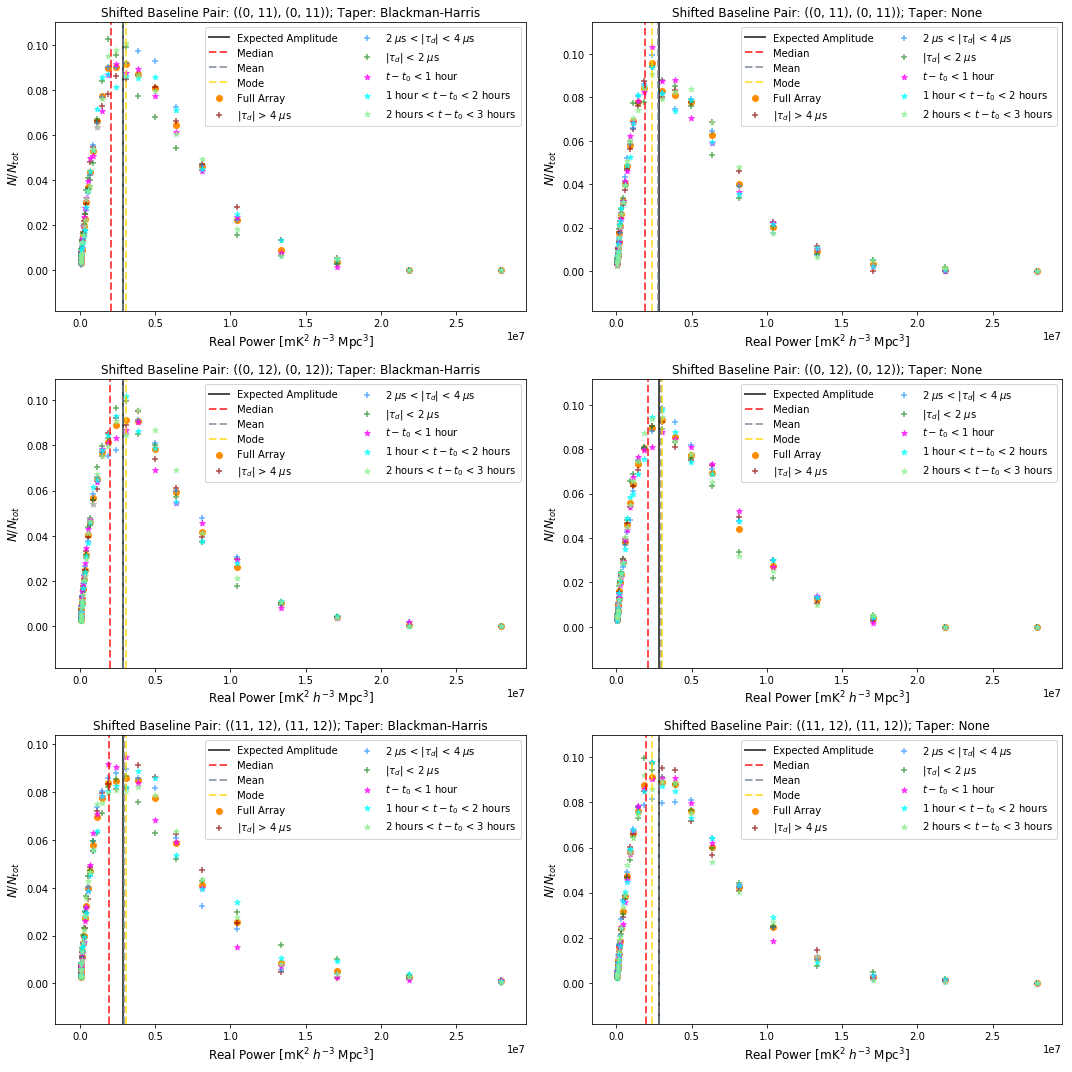

In [23]:
# Plot histograms for each autobaseline pair
fig = plt.figure(figsize=(15,15))
axes = fig.subplots(3,2)
shifted = True
save = False

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        blp = autopairs[i]
        taper = autospectra.keys()[j]
        if taper=='untapered':
            tapername = 'None'
        else:
            tapername = 'Blackman-Harris'
        if shifted:
            shiftname = 'Shifted'
            skey = 'shifted'
        else:
            shiftname = 'Unshifted'
            skey = 'unshifted'
        
        # Make histogram for all measured power
        
        spec = np.abs(np.real(autospectra[taper][skey][blp]))
        bins = np.linspace(4.5,7.5,29)
        powers = 10**(0.5*(bins[1:] + bins[:-1]))
        hist = 1.0*np.histogram(np.log10(spec), bins=bins)[0]
        
        # Slice power spectra by delay
        
        dkey1 = np.where(np.abs(uvp.dly_array * 1e9) > 4000)
        dkey2 = np.where(np.abs(np.abs(uvp.dly_array * 1e9) - 3000) < 1000)
        dkey3 = np.where(np.abs(uvp.dly_array * 1e9) < 2000)
        
        # Slice power spectra by observation time
        
        time_avg = 24*np.unique(uvp.time_avg_array - uvp.time_avg_array[0])
        tkey1 = np.where(time_avg < 1)
        tkey2 = np.where(np.abs(time_avg-1.5)<0.5)
        tkey3 = np.where(time_avg > 2)

        # Extract sliced spectra
        
        dspec1 = spec[:,dkey1[0]]
        dspec2 = spec[:,dkey2[0]]
        dspec3 = spec[:,dkey3[0]]
        dlabel1 = r'$|\tau_d|$ > 4 $\mu$s'
        dlabel2 = r'2 $\mu$s < $|\tau_d|$ < 4 $\mu$s'
        dlabel3 = r'$|\tau_d|$ < 2 $\mu$s'

        tspec1 = spec[tkey1[0],:]
        tspec2 = spec[tkey2[0],:]
        tspec3 = spec[tkey3[0],:]
        tlabel1 = r'$t - t_{0}$ < 1 hour'
        tlabel2 = r'1 hour < $t - t_{0}$ < 2 hours'
        tlabel3 = r'2 hours < $t - t_{0}$ < 3 hours'
        
        # Construct histograms
        
        dhist1 = 1.0*np.histogram(np.log10(dspec1), bins=bins)[0]
        dhist2 = 1.0*np.histogram(np.log10(dspec2), bins=bins)[0]
        dhist3 = 1.0*np.histogram(np.log10(dspec3), bins=bins)[0]
        
        thist1 = 1.0*np.histogram(np.log10(tspec1), bins=bins)[0]
        thist2 = 1.0*np.histogram(np.log10(tspec2), bins=bins)[0]
        thist3 = 1.0*np.histogram(np.log10(tspec3), bins=bins)[0]
        
        # Compute mean, median, and mode for comparison to noise level
        
        mean = np.mean(spec)
        median = np.median(spec)
        mode = powers[np.where(hist==hist.max())]
        
        # Label axes
        
        axes[i,j].set_xlabel(r'Real Power [mK$^2$ $h^{-3}$ Mpc$^3$]', fontsize=12)
        axes[i,j].set_ylabel(r'$N/N_{tot}$', fontsize=12)
        axes[i,j].set_title('{} Baseline Pair: {}; Taper: {}'.format(shiftname, blp, tapername))
        
        # Plot histograms
        
        axes[i,j].scatter(powers, hist/hist.sum(), color='darkorange', label='Full Array')
        
        axes[i,j].scatter(powers, dhist1/dhist1.sum(), marker='+', color='darkred', alpha=0.7, label=dlabel1)
        axes[i,j].scatter(powers, dhist2/dhist2.sum(), marker='+', color='dodgerblue', alpha = 0.7, label=dlabel2)
        axes[i,j].scatter(powers, dhist3/dhist3.sum(), marker='+', color='forestgreen', alpha=0.7, label=dlabel3)
        
        axes[i,j].scatter(powers, thist1/thist1.sum(), marker='*', color='magenta', alpha=0.7, label=tlabel1)
        axes[i,j].scatter(powers, thist2/thist2.sum(), marker='*', color='cyan', alpha=0.7, label=tlabel2)
        axes[i,j].scatter(powers, thist3/thist3.sum(), marker='*', color='lightgreen', alpha=0.7, label=tlabel3)
        
        axes[i,j].axvline(sig_amp, color='k', lw=2, alpha=0.7, label='Expected Amplitude')
        axes[i,j].axvline(median, color='red', ls='--', lw=2, alpha=0.7, label='Median')
        axes[i,j].axvline(mean, color='slategray', ls='--', lw=2, alpha=0.7, label='Mean')
        axes[i,j].axvline(mode, color='gold', ls='--', lw=2, alpha=0.7, label='Mode')
        
        axes[i,j].legend(loc='upper right', ncol=2)
        
plt.tight_layout()
plt.show()
if save:
    fig.savefig('Plots/Histograms/Take2/Gaussian_Sky_Histograms_Real_Power_{}.png'.format(shiftname))
    fig.savefig('Plots/Histograms/Take2/Gaussian_Sky_Histograms_Real_Power_{}.pdf'.format(shiftname))

**Figure 5** | Histograms of the absolute value of the real component of the measured power spectra, calculated using the shifted visibilities. No averaging was performed on any of the histograms plotted; they are simply slices in observation time or delay mode. There is no obvious difference between histograms for the various slices taken, nor is there a clear difference between baselines. Note that the bins are spaced log-uniformly, so the bins at lower powers are smaller; this influences the apparent shape of the distribution.

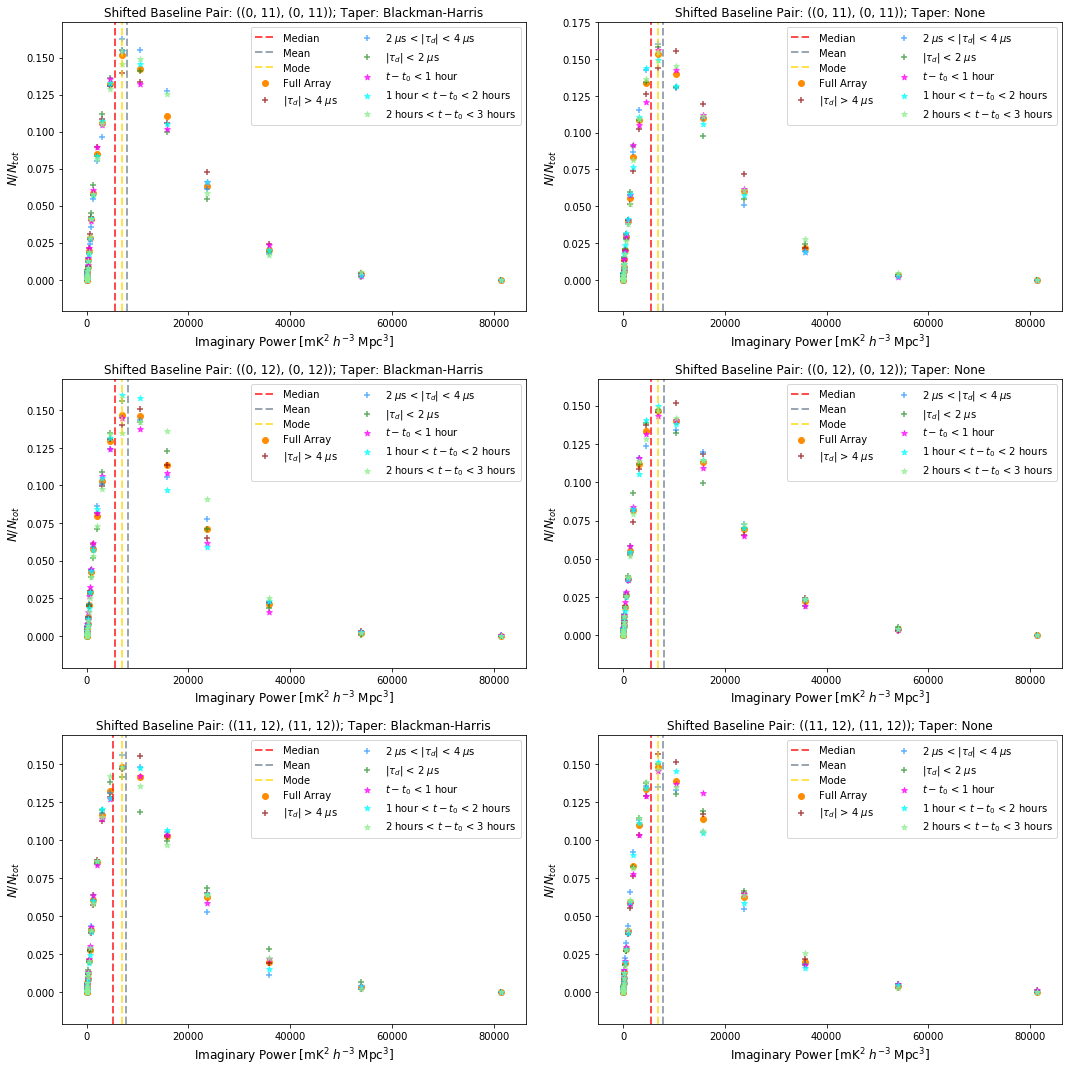

In [25]:
# Plot histograms for each autobaseline pair
fig = plt.figure(figsize=(15,15))
axes = fig.subplots(3,2)
shifted = True
save = False

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        blp = autopairs[i]
        taper = autospectra.keys()[j]
        if taper=='untapered':
            tapername = 'None'
        else:
            tapername = 'Blackman-Harris'
        if shifted:
            shiftname = 'Shifted'
            skey = 'shifted'
        else:
            shiftname = 'Unshifted'
            skey = 'unshifted'
        
        # Make histogram for all measured power
        
        spec = np.abs(np.imag(autospectra[taper][skey][blp]))
        bins = np.linspace(0,5,29)
        powers = 10**(0.5*(bins[1:] + bins[:-1]))
        hist = 1.0*np.histogram(np.log10(spec), bins=bins)[0]
        
        # Slice power spectra by delay
        
        dkey1 = np.where(np.abs(uvp.dly_array * 1e9) > 4000)
        dkey2 = np.where(np.abs(np.abs(uvp.dly_array * 1e9) - 3000) < 1000)
        dkey3 = np.where(np.abs(uvp.dly_array * 1e9) < 2000)
        
        # Slice power spectra by observation time
        
        time_avg = 24*np.unique(uvp.time_avg_array - uvp.time_avg_array[0])
        tkey1 = np.where(time_avg < 1)
        tkey2 = np.where(np.abs(time_avg-1.5)<0.5)
        tkey3 = np.where(time_avg > 2)

        # Extract sliced spectra
        
        dspec1 = spec[:,dkey1[0]]
        dspec2 = spec[:,dkey2[0]]
        dspec3 = spec[:,dkey3[0]]
        dlabel1 = r'$|\tau_d|$ > 4 $\mu$s'
        dlabel2 = r'2 $\mu$s < $|\tau_d|$ < 4 $\mu$s'
        dlabel3 = r'$|\tau_d|$ < 2 $\mu$s'

        tspec1 = spec[tkey1[0],:]
        tspec2 = spec[tkey2[0],:]
        tspec3 = spec[tkey3[0],:]
        tlabel1 = r'$t - t_{0}$ < 1 hour'
        tlabel2 = r'1 hour < $t - t_{0}$ < 2 hours'
        tlabel3 = r'2 hours < $t - t_{0}$ < 3 hours'
        
        # Construct histograms
        
        dhist1 = 1.0*np.histogram(np.log10(dspec1), bins=bins)[0]
        dhist2 = 1.0*np.histogram(np.log10(dspec2), bins=bins)[0]
        dhist3 = 1.0*np.histogram(np.log10(dspec3), bins=bins)[0]
        
        thist1 = 1.0*np.histogram(np.log10(tspec1), bins=bins)[0]
        thist2 = 1.0*np.histogram(np.log10(tspec2), bins=bins)[0]
        thist3 = 1.0*np.histogram(np.log10(tspec3), bins=bins)[0]
        
        # Compute mean, median, and mode for comparison to noise level
        
        mean = np.mean(spec)
        median = np.median(spec)
        mode = powers[np.where(hist==hist.max())]
        
        # Label axes
        
        axes[i,j].set_xlabel(r'Imaginary Power [mK$^2$ $h^{-3}$ Mpc$^3$]', fontsize=12)
        axes[i,j].set_ylabel(r'$N/N_{tot}$', fontsize=12)
        axes[i,j].set_title('{} Baseline Pair: {}; Taper: {}'.format(shiftname, blp, tapername))
        
        # Plot histograms
        
        axes[i,j].scatter(powers, hist/hist.sum(), color='darkorange', label='Full Array')
        
        axes[i,j].scatter(powers, dhist1/dhist1.sum(), marker='+', color='darkred', alpha=0.7, label=dlabel1)
        axes[i,j].scatter(powers, dhist2/dhist2.sum(), marker='+', color='dodgerblue', alpha = 0.7, label=dlabel2)
        axes[i,j].scatter(powers, dhist3/dhist3.sum(), marker='+', color='forestgreen', alpha=0.7, label=dlabel3)
        
        axes[i,j].scatter(powers, thist1/thist1.sum(), marker='*', color='magenta', alpha=0.7, label=tlabel1)
        axes[i,j].scatter(powers, thist2/thist2.sum(), marker='*', color='cyan', alpha=0.7, label=tlabel2)
        axes[i,j].scatter(powers, thist3/thist3.sum(), marker='*', color='lightgreen', alpha=0.7, label=tlabel3)
        
        
#        axes[i,j].axvline(sig_amp, color='k', lw=2, alpha=0.7, label='Expected Amplitude')
        axes[i,j].axvline(median, color='red', ls='--', lw=2, alpha=0.7, label='Median')
        axes[i,j].axvline(mean, color='slategray', ls='--', lw=2, alpha=0.7, label='Mean')
        axes[i,j].axvline(mode, color='gold', ls='--', lw=2, alpha=0.7, label='Mode')
        
        axes[i,j].legend(loc='upper right', ncol=2)
        
plt.tight_layout()
plt.show()
if save:
    fig.savefig('Plots/Histograms/Take2/Gaussian_Sky_Histograms_Imaginary_Power_{}.png'.format(shiftname))
    fig.savefig('Plots/Histograms/Take2/Gaussian_Sky_Histograms_Imaginary_Power_{}.pdf'.format(shiftname))

**Figure 6** | Histograms of the absolute value of the imaginary component of the measured power spectra, computed using the shifted visibilities.

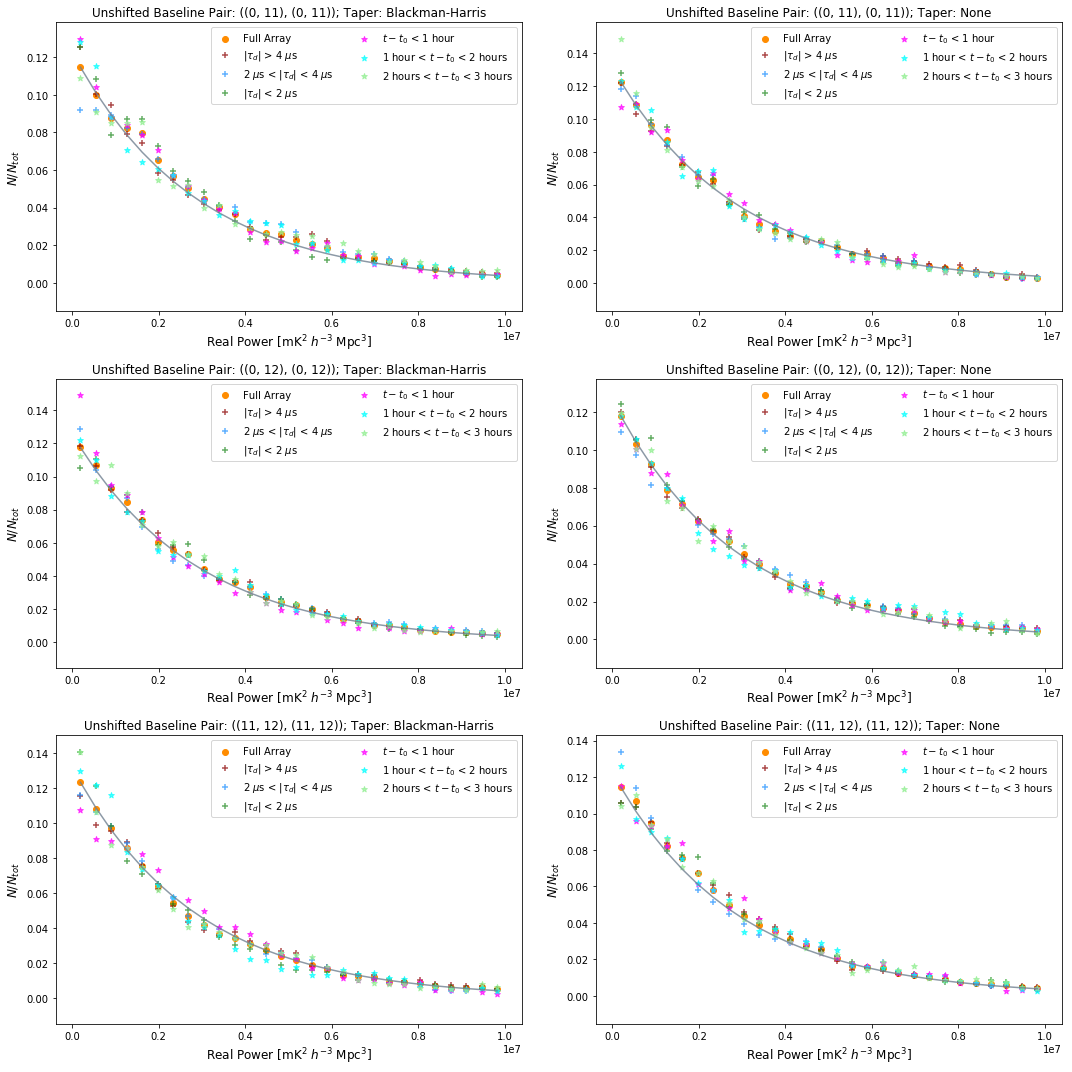

In [31]:
# Plot histograms for each autobaseline pair
fig = plt.figure(figsize=(15,15))
axes = fig.subplots(3,2)
shifted = False
save = False
errors = np.zeros(3*2*3).reshape(3,2,3)

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        blp = autopairs[i]
        taper = autospectra.keys()[j]
        if taper=='untapered':
            tapername = 'None'
        else:
            tapername = 'Blackman-Harris'
        if shifted:
            shiftname = 'Shifted'
            skey = 'shifted'
        else:
            shiftname = 'Unshifted'
            skey = 'unshifted'
        
        # Make histogram for all measured power
        
        spec = np.abs(np.real(autospectra[taper][skey][blp]))
        bins = np.linspace(10**4,10**7,29)
        powers = 0.5*(bins[1:] + bins[:-1])
        hist = 1.0*np.histogram(spec, bins=bins)[0]
        
        # Slice power spectra by delay
        
        dkey1 = np.where(np.abs(uvp.dly_array * 1e9) > 4000)
        dkey2 = np.where(np.abs(np.abs(uvp.dly_array * 1e9) - 3000) < 1000)
        dkey3 = np.where(np.abs(uvp.dly_array * 1e9) < 2000)
        
        # Slice power spectra by observation time
        
        time_avg = 24*np.unique(uvp.time_avg_array - uvp.time_avg_array[0])
        tkey1 = np.where(time_avg < 1)
        tkey2 = np.where(np.abs(time_avg-1.5)<0.5)
        tkey3 = np.where(time_avg > 2)

        # Extract sliced spectra
        
        dspec1 = spec[:,dkey1[0]]
        dspec2 = spec[:,dkey2[0]]
        dspec3 = spec[:,dkey3[0]]
        dlabel1 = r'$|\tau_d|$ > 4 $\mu$s'
        dlabel2 = r'2 $\mu$s < $|\tau_d|$ < 4 $\mu$s'
        dlabel3 = r'$|\tau_d|$ < 2 $\mu$s'

        tspec1 = spec[tkey1[0],:]
        tspec2 = spec[tkey2[0],:]
        tspec3 = spec[tkey3[0],:]
        tlabel1 = r'$t - t_{0}$ < 1 hour'
        tlabel2 = r'1 hour < $t - t_{0}$ < 2 hours'
        tlabel3 = r'2 hours < $t - t_{0}$ < 3 hours'
        
        # Construct histograms
        
        dhist1 = 1.0*np.histogram(dspec1, bins=bins)[0]
        dhist2 = 1.0*np.histogram(dspec2, bins=bins)[0]
        dhist3 = 1.0*np.histogram(dspec3, bins=bins)[0]
        
        thist1 = 1.0*np.histogram(tspec1, bins=bins)[0]
        thist2 = 1.0*np.histogram(tspec2, bins=bins)[0]
        thist3 = 1.0*np.histogram(tspec3, bins=bins)[0]
        
        # Compute mean, median, and mode for comparison to expected amplitude
        
        mean = np.mean(spec)
        median = np.median(spec)
        mode = powers[np.where(hist==hist.max())]
        errors[i,j,0] = (sig_amp-mean)/sig_amp
        errors[i,j,1] = (sig_amp-median)/sig_amp
        errors[i,j,2] = (sig_amp-mode)/sig_amp
        
        # Generate exponential distribution to compare
        exp = np.exp(-powers/sig_amp)
        
        # Label axes
        
        axes[i,j].set_xlabel(r'Real Power [mK$^2$ $h^{-3}$ Mpc$^3$]', fontsize=12)
        axes[i,j].set_ylabel(r'$N/N_{tot}$', fontsize=12)
        axes[i,j].set_title('{} Baseline Pair: {}; Taper: {}'.format(shiftname, blp, tapername))
        
        # Plot histograms
        
        axes[i,j].scatter(powers, hist/hist.sum(), color='darkorange', label='Full Array')
        
        axes[i,j].scatter(powers, dhist1/dhist1.sum(), marker='+', color='darkred', alpha=0.7, label=dlabel1)
        axes[i,j].scatter(powers, dhist2/dhist2.sum(), marker='+', color='dodgerblue', alpha = 0.7, label=dlabel2)
        axes[i,j].scatter(powers, dhist3/dhist3.sum(), marker='+', color='forestgreen', alpha=0.7, label=dlabel3)
        
        axes[i,j].scatter(powers, thist1/thist1.sum(), marker='*', color='magenta', alpha=0.7, label=tlabel1)
        axes[i,j].scatter(powers, thist2/thist2.sum(), marker='*', color='cyan', alpha=0.7, label=tlabel2)
        axes[i,j].scatter(powers, thist3/thist3.sum(), marker='*', color='lightgreen', alpha=0.7, label=tlabel3)
        
#        axes[i,j].axvline(sig_amp, color='k', lw=2, alpha=0.7, label='Expected Amplitude')
#        axes[i,j].axvline(median, color='red', ls='--', lw=2, alpha=0.7, label='Median')
#        axes[i,j].axvline(mean, color='slategray', ls='--', lw=2, alpha=0.7, label='Mean')
#        axes[i,j].axvline(mode, color='gold', ls='--', lw=2, alpha=0.7, label='Mode')
        
        axes[i,j].plot(powers, exp*hist.max()/(hist.sum()*exp.max()), color='slategray', alpha=0.8)
        
        axes[i,j].legend(loc='upper right', ncol=2)
        
plt.tight_layout()
plt.show()
if save:
    fig.savefig('Plots/Histograms/Take2/Gaussian_Sky_Histograms_Real_Power_{}.png'.format(shiftname))
    fig.savefig('Plots/Histograms/Take2/Gaussian_Sky_Histograms_Real_Power_{}.pdf'.format(shiftname))

**Figure 7** | Histograms of the absolute value of the real component of the measured power spectra, computed using unshifted visibilities. These histograms look different than the previous histograms since the bins are linearly uniform here. An exponential distribution is overplotted with the histograms and appears to be in good agreement.

In [33]:
# Look at deviation from expected amplitude for mean, median, and mode
# Discrepancies calculated for spectra obtained from unshifted visibilities

# Note that the mode here is very far off from the expected amplitude. The mode calculated here depends on how
# the spectra are binned. Regardless, the discrepancy between the mode and the measured result are in poor
# agreement even for log-uniform bin sizes.
stat = ['mean', 'median', 'mode']
print('Discrepancy is computed as (sig_amp-stat)/sig_amp.')
print('')
for i in range(errors.shape[0]):
    for j in range(errors.shape[1]):
        for k in range(errors.shape[2]):
            blp = autopairs[i]
            taper = autospectra.keys()[j]
            label = stat[k]
            print('taper: {}; blp: {}; statistic: {}; discrepancy: {:2.2f}%'.format(taper, blp, label, 100*errors[i,j,k]))
            if k==2:
                print('')

Discrepancy is computed as (sig_amp-stat)/sig_amp.

taper: tapered; blp: ((0, 11), (0, 11)); statistic: mean; discrepancy: -1.22%
taper: tapered; blp: ((0, 11), (0, 11)); statistic: median; discrepancy: 28.36%
taper: tapered; blp: ((0, 11), (0, 11)); statistic: mode; discrepancy: 93.38%

taper: untapered; blp: ((0, 11), (0, 11)); statistic: mean; discrepancy: 2.92%
taper: untapered; blp: ((0, 11), (0, 11)); statistic: median; discrepancy: 32.77%
taper: untapered; blp: ((0, 11), (0, 11)); statistic: mode; discrepancy: 93.38%

taper: tapered; blp: ((0, 12), (0, 12)); statistic: mean; discrepancy: -1.03%
taper: tapered; blp: ((0, 12), (0, 12)); statistic: median; discrepancy: 29.38%
taper: tapered; blp: ((0, 12), (0, 12)); statistic: mode; discrepancy: 93.38%

taper: untapered; blp: ((0, 12), (0, 12)); statistic: mean; discrepancy: -3.65%
taper: untapered; blp: ((0, 12), (0, 12)); statistic: median; discrepancy: 26.89%
taper: untapered; blp: ((0, 12), (0, 12)); statistic: mode; discrepanc

In [34]:
# Imaginary power for spectra generated using unshifted visibilities is basically zero
for key in autospectra.keys():
    for blp in autopairs:
        spec = np.abs(np.imag(autospectra[key]['unshifted'][blp]))
        print('taper: {}; blp: {}; Maximum Imaginary Power: {:3.2e} [mK units]'.format(key, blp, spec.max()))

taper: tapered; blp: ((0, 11), (0, 11)); Maximum Imaginary Power: 7.21e-09 [mK units]
taper: tapered; blp: ((0, 12), (0, 12)); Maximum Imaginary Power: 8.02e-09 [mK units]
taper: tapered; blp: ((11, 12), (11, 12)); Maximum Imaginary Power: 1.22e-08 [mK units]
taper: untapered; blp: ((0, 11), (0, 11)); Maximum Imaginary Power: 1.43e-08 [mK units]
taper: untapered; blp: ((0, 12), (0, 12)); Maximum Imaginary Power: 1.03e-08 [mK units]
taper: untapered; blp: ((11, 12), (11, 12)); Maximum Imaginary Power: 1.19e-08 [mK units]
